# Addition experiment

An implementation of sequence to sequence learning for performing addition

* Input: "535+61"

* Output: "596"

Padding is handled by using a repeated sentinel character (space)
Input may optionally be inverted, shown to increase performance in many tasks in:
"Learning to Execute"
http://arxiv.org/abs/1410.4615
and
"Sequence to Sequence Learning with Neural Networks"
http://papers.nips.cc/paper/5346-sequence-to-sequence-learning-with-neural-networks.pdf
Theoretically it introduces shorter term dependencies between source and target.
Two digits inverted:
+ One layer LSTM (128 HN), 5k training examples = 99% train/test accuracy in 55 epochs
Three digits inverted:
+ One layer LSTM (128 HN), 50k training examples = 99% train/test accuracy in 100 epochs
Four digits inverted:
+ One layer LSTM (128 HN), 400k training examples = 99% train/test accuracy in 20 epochs
Five digits inverted:
+ One layer LSTM (128 HN), 550k training examples = 99% train/test accuracy in 30 epochs

In [1]:
import numpy as np
import tqdm
import theano
import theano.tensor as T
import lasagne
from lasagne.layers import *

import matplotlib.pyplot as plt
%matplotlib inline

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Can not use cuDNN on context None: cannot compile with cuDNN. We got this error:
b'C:\\Users\\tumanov\\AppData\\Local\\Temp\\try_flags_lv_rqodj.c:4:19: fatal error: cudnn.h: No such file or directory\r\ncompilation terminated.\r\n'
Mapped name None to device cuda0: GeForce GTX 1070 (0000:01:00.0)


## Utils

In [2]:
def non_trainable(net):
    for tags in net.params.values():
        tags -= {'trainable', 'regularizable'}
    return net

## Parameters

In [3]:
# Parameters for the model and dataset.
TRAINING_SIZE = 50000
DIGITS = 3
INVERT = True

In [4]:
# Try replacing GRU, or SimpleRNN.
HIDDEN_SIZE = 128
LAYERS = 1

## Generating data

In [5]:
def generate_data(size, digits):
    source_seqs = []
    target_seqs = []
    seen = set()
    print('Generating data...')
    while len(source_seqs) < TRAINING_SIZE:
        f = lambda: int(''.join(np.random.choice(list('0123456789'))
                        for i in range(np.random.randint(1, DIGITS + 1))))
        a, b = f(), f()
        # Skip any addition questions we've already seen
        # Also skip any such that x+Y == Y+x (hence the sorting).
        key = tuple(sorted((a, b)))
        if key in seen:
            continue
        seen.add(key)
        # Pad the data with spaces such that it is always MAXLEN.
        q = '{}+{}'.format(a, b)
        ans = str(a + b)

        source_seqs.append(q)
        target_seqs.append(["START"] + list(ans) + ["END"])

    print('Total addition questions:', len(source_seqs))
    
    target_letters = list(set([token for ts in target_seqs for token in ts]))
    target_letter_to_ix = {ph:i for i,ph in enumerate(target_letters)}
    
    source_letters = list(set([token for word in source_seqs for token in word]))
    source_letter_to_ix = {l:i for i,l in enumerate(source_letters)}
    
    return source_seqs, source_letters, source_letter_to_ix, \
           target_seqs, target_letters, target_letter_to_ix

In [6]:
source_seqs, source_letters, source_letter_to_ix, target_seqs, target_letters, target_letter_to_ix =\
                    generate_data(TRAINING_SIZE, DIGITS)

Generating data...
Total addition questions: 50000


In [7]:
for source, target in zip(source_seqs[:5],target_seqs[:5]):
    print( source,':',"".join(target[1:-1]))

668+1 : 669
45+570 : 615
0+586 : 586
3+44 : 47
527+0 : 527


In [8]:
source_letters = list(set([token for word in source_seqs for token in word]))
source_letter_to_ix = {l:i for i,l in enumerate(source_letters)}

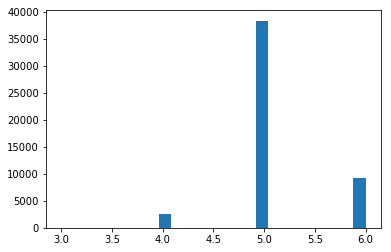

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(list(map(len,target_seqs)),bins=25);

# Truncate names longer than MAX_LEN characters. This can be changed
MAX_LEN = min([150,max(list(map(len, target_seqs)))])

## Cast everything from symbols into matrix of int32. Pad with -1

In [9]:
def as_matrix(sequences, token_to_i, max_len=None, PAX_ix=-1):
    """
    Converts several sequences of tokens to a matrix, edible a neural network.
    Crops at max_len(if given), pads shorter sequences with -1 or PAD_ix.
    """
    max_len = max_len or max(map(len,sequences))
    
    matrix = np.zeros((len(sequences),max_len),dtype='int8') -1
    for i,seq in enumerate(sequences):
        
        row_ix = [token_to_i.get(_, 0) for _ in seq[:max_len]]
        matrix[i,:len(row_ix)] = row_ix
    
    return matrix


## Input vars

In [10]:
input_sequence = T.matrix('token sequence', 'int32')
output_sequence = T.matrix('target target_letters', 'int32')

## Classic model

In [11]:

##ENCODER
l_in = InputLayer(shape=(None, None),input_var=input_sequence)
l_mask = InputLayer(shape=(None, None),input_var=T.neq(input_sequence,-1)) 


l_emb = non_trainable(EmbeddingLayer(l_in, len(source_letters),  len(source_letters), W=np.diag(np.ones(len(source_letters)))))
l_rnn = LSTMLayer(l_emb, HIDDEN_SIZE, only_return_final=True, mask_input=l_mask)

In [12]:
##DECODER
dec_in = InputLayer(shape=(None, None),input_var=output_sequence)
dec_mask = InputLayer(shape=(None, None),input_var=T.neq(output_sequence,-1))

dec_emb = non_trainable(EmbeddingLayer(dec_in, len(target_letters), len(target_letters), W=np.diag(np.ones(len(target_letters)))))
dec_rnn = LSTMLayer(dec_emb, num_units=HIDDEN_SIZE, cell_init=l_rnn, mask_input=dec_mask)
# WARNING! if it's lstm use cell_init, not hid_init


#flatten batch and time to be compatible with feedforward layers (will un-flatten later)
dec_rnn_flat = reshape(dec_rnn, (-1,dec_rnn.output_shape[-1]))

l_out = DenseLayer(dec_rnn_flat, len(target_letters), nonlinearity=lasagne.nonlinearities.softmax)

In [13]:
def handle_model(nn):
    # Model weights
    weights = get_all_params(nn)
    network_output = get_output(nn)
    network_output = network_output.reshape([output_sequence.shape[0],\
                                         output_sequence.shape[1], -1])
    predictions_flat = network_output[:,:-1,:].reshape([-1,len(target_letters)])
    targets = output_sequence[:,1:].ravel()

    #do not count loss for '-1' tokens
    mask = T.nonzero(T.neq(targets,-1))

    loss = lasagne.objectives.categorical_crossentropy(predictions_flat[mask], targets[mask]).mean()
    updates = lasagne.updates.adam(loss,weights)
    #training
    train = theano.function([input_sequence, output_sequence], loss, updates=updates, allow_input_downcast=True)

    #computing loss without training
    compute_cost = theano.function([input_sequence, output_sequence], loss, allow_input_downcast=True)
    #compile the function that computes probabilities for next token given previous text.

    last_probas =network_output[:, -1]

    probs = theano.function([input_sequence, output_sequence], last_probas)
    return train, compute_cost, probs

In [14]:
train, compute_cost, probs = handle_model(l_out)

# Generation

We now need to implement a function that generates output sequence given input.

Such function must work thusly:
```
Init:
x = input
y = ["START"]

While not_too_long:
  p(y_next|x,y) = probabilities of next letter for y
  
  y_next ~ p(y_next|x,y)
  
  y.append(y_next)
  
  if y_next == "END":
      break
```

In [15]:
def generate_output(input, probs, target_letters, target_letter_to_ix, source_letter_to_ix,
                    output_prefix = ("START",),
                    END_token="END",
                    temperature=1,
                    sample=True):
    
    """
    Implement a function that generates output sequence given input.
    
    We recommend (but not require) you to use the pseudo-code above and inline instructions.
    """
    x = as_matrix([input], source_letter_to_ix) 
    output = list(output_prefix)
    while True:
        y = as_matrix([output], target_letter_to_ix)
        next_y_probs = probs(x, y)
        next_y_probs = (next_y_probs ** temperature) / (next_y_probs ** temperature).sum()
        if sample:
            next_y = np.random.choice(target_letters, p=next_y_probs[0])
        else:
            next_y = target_letters[next_y_probs[0].argmax()]
        next_y = str(next_y)             
        assert type(next_y) is str, "please return token(string/character), not it's index"
        
        output.append(next_y)

        if next_y==END_token:
            break
            
    return output



## Model training

In [16]:
source_seqs = np.array(source_seqs)
target_seqs = np.array(target_seqs)

In [17]:
def sample_batch(source_seqs, source_letter_to_ix, target_seqs, target_letter_to_ix, batch_size):
    """samples a random batch of source and target sequences, batch_size elements"""
    batch_ix = np.random.randint(0,len(source_seqs),size=batch_size)
    source_seqs_batch=as_matrix(source_seqs[batch_ix], source_letter_to_ix) 
    target_seqs_batch=as_matrix(target_seqs[batch_ix], target_letter_to_ix)
    
    return source_seqs_batch,target_seqs_batch

In [18]:
#total N iterations
n_epochs=10

# how many minibatches are there in the epoch 
batches_per_epoch = 500

#how many training sequences are processed in a single function call
batch_size=64


for epoch in range(n_epochs):
    try:

        avg_cost = 0;

        for _ in range(batches_per_epoch):

            x,y = sample_batch(source_seqs, source_letter_to_ix, target_seqs, target_letter_to_ix, batch_size)
            avg_cost += train(x, y).mean()

        print("Epoch {} average loss = {}".format(epoch, avg_cost / batches_per_epoch))
        for i in range(5):
            ind = np.random.randint(len(source_seqs))
            print (source_seqs[ind],':', ''.join(generate_output(source_seqs[ind], probs, target_letters, target_letter_to_ix, \
                                                             source_letter_to_ix, sample=True)[1:-1]))


    except KeyboardInterrupt:
        break

Epoch 0 average loss = 1.72235736110291
0+677 : 156
2+274 : 986
38+285 : 496
419+1 : 121
578+4 : 703
Epoch 1 average loss = 1.4547770704240068
8+775 : 784
956+804 : 1582
314+59 : 356
377+37 : 446
335+168 : 442
Epoch 2 average loss = 1.2557770901860552
61+340 : 389
13+412 : 435
448+371 : 872
283+475 : 797
34+53 : 60
Epoch 3 average loss = 1.121578669989569
11+406 : 273
696+87 : 866
343+85 : 402
100+909 : 1014
528+29 : 545
Epoch 4 average loss = 1.0221197427451496
36+74 : 112
35+18 : 47
538+832 : 1370
105+1 : 109
742+31 : 762
Epoch 5 average loss = 0.9404933533314098
78+597 : 658
9+891 : 898
31+988 : 1017
871+275 : 1151
61+98 : 161
Epoch 6 average loss = 0.8832813741927545
199+31 : 223
82+5 : 100
347+765 : 1114
18+612 : 628
778+60 : 829
Epoch 7 average loss = 0.8309315052543846
601+58 : 656
74+817 : 890
219+54 : 239
967+339 : 1244
141+343 : 496
Epoch 8 average loss = 0.7833198556252612
959+91 : 1029
48+148 : 197
10+12 : 30
536+382 : 915
497+6 : 500
Epoch 9 average loss = 0.75076938986746

## Bazal module

In [51]:
class CerMemory(lasagne.layers.Layer):
    def __init__(self, incoming, memory_size, M=lasagne.init.Orthogonal(), **kwargs):
        super(CerMemory, self).__init__(incoming, **kwargs)
        self.query_shape = self.input_shape[1]
        self.memory_size = memory_size
        self.M = self.add_param(M, (self.query_shape, memory_size), name='M')

    def get_output_for(self, input, **kwargs):
        m = self.M / T.sqrt(T.sqr(self.M).sum(axis=0)).reshape(self.M.shape[1], 1)
        weights =  T.dot(input, m)
        return T.dot(weights, m.T)
    
    def get_output_shape_for(self, input_shape):
        return (input_shape[0], self.query_shape)

In [63]:
class EvcNormalizer(lasagne.layers.Layer):
    def get_output_for(self, input, **kwargs):
        return (input.T / T.sqrt(T.sqr(input).sum(axis=1)).reshape(input.shape[0], 1)).T

In [64]:
QUERY_SIZE = 16
MEMORY_SIZE = 64

In [65]:
def bazal_model(query_size, memory_size):

    ##ENCODER
    l_in = InputLayer(shape=(None, None),input_var=input_sequence)
    l_mask = InputLayer(shape=(None, None),input_var=T.neq(input_sequence,-1)) 


    l_emb = non_trainable(EmbeddingLayer(l_in, len(source_letters),  len(source_letters), W=np.diag(np.ones(len(source_letters)))))
    features = LSTMLayer(l_emb, HIDDEN_SIZE, only_return_final=True, mask_input=l_mask)
    ## QUERY BUILDER
    query = DenseLayer(features, QUERY_SIZE, nonlinearity=None)
    query = EvcNormalizer(query)
    ## Memory
    memory = CerMemory(query, MEMORY_SIZE)
    
    to_decode = ConcatLayer([features, memory])
    
    ##DECODER
    dec_in = InputLayer(shape=(None, None),input_var=output_sequence)
    dec_mask = InputLayer(shape=(None, None),input_var=T.neq(output_sequence,-1))

    dec_emb = non_trainable(EmbeddingLayer(dec_in, len(target_letters), len(target_letters), W=np.diag(np.ones(len(target_letters)))))
    dec_rnn = LSTMLayer(dec_emb, num_units=to_decode.output_shape[-1], cell_init=to_decode, mask_input=dec_mask)
    # WARNING! if it's lstm use cell_init, not hid_init


    #flatten batch and time to be compatible with feedforward layers (will un-flatten later)
    dec_rnn_flat = reshape(dec_rnn, (-1,dec_rnn.output_shape[-1]))

    l_out = DenseLayer(dec_rnn_flat, len(target_letters), nonlinearity=lasagne.nonlinearities.softmax)
    return l_out, memory

In [66]:
l_out, memory = bazal_model(QUERY_SIZE, MEMORY_SIZE)

In [67]:
train, compute_cost, probs = handle_model(l_out)

In [68]:
#total N iterations
n_epochs=10

# how many minibatches are there in the epoch 
batches_per_epoch = 500

#how many training sequences are processed in a single function call
batch_size=64


for epoch in range(n_epochs):
    try:

        avg_cost = 0;

        for _ in range(batches_per_epoch):

            x,y = sample_batch(source_seqs, source_letter_to_ix, target_seqs, target_letter_to_ix, batch_size)
            avg_cost += train(x, y).mean()

        print("Epoch {} average loss = {}".format(epoch, avg_cost / batches_per_epoch))
        for i in range(5):
            ind = np.random.randint(len(source_seqs))
            print (source_seqs[ind],':', ''.join(generate_output(source_seqs[ind], probs, target_letters, target_letter_to_ix, \
                                                             source_letter_to_ix, sample=True)[1:-1]))


    except KeyboardInterrupt:
        break

Epoch 0 average loss = 1.6863881913490928
990+8 : 987
215+1 : 22
1+910 : 738
5+897 : 518
16+167 : 251
Epoch 1 average loss = 1.347186820833203
161+65 : 261
125+25 : 27
557+6 : 573
110+25 : 132
608+16 : 618
Epoch 2 average loss = 1.1719685744079509
549+246 : 778
83+494 : 535
281+373 : 666
459+38 : 471
301+625 : 970
Epoch 3 average loss = 1.0526060302232518
72+912 : 977
20+414 : 441
71+915 : 1002
91+763 : 846
522+23 : 556
Epoch 4 average loss = 0.949715852765253
253+93 : 357
29+305 : 434
774+916 : 1671
51+319 : 361
650+72 : 739
Epoch 5 average loss = 0.8659991489751153
4+119 : 219
821+34 : 859
693+74 : 769
2+201 : 212
561+741 : 1337
Epoch 6 average loss = 0.7963561874314545
55+54 : 116
134+247 : 384
21+992 : 1019
6+811 : 813
963+59 : 1025
Epoch 7 average loss = 0.7303057232907519
8+869 : 878
27+358 : 392
333+84 : 410
437+857 : 1290
462+4 : 471
Epoch 8 average loss = 0.6707419930811301
621+47 : 668
588+277 : 857
825+18 : 840
53+549 : 598
97+607 : 699
Epoch 9 average loss = 0.6080882297174

In [69]:
M_add = np.array(memory.M.eval())

## Same for prod problem